In [1]:
# parse dev data function
def ParseJson(data_json):
    paragraphs = data_json['data'][0]['paragraphs']
    idx_list = list()
    context_list = list()
    ques_list = list()
    ans_list = list()
    for para in paragraphs:
        context = para['context']
        idx = para['qas'][0]['id']
        ques = para['qas'][0]['question']
        ans = '|||'.join([ans['text'] for ans in para['qas'][0]['answers']])
        idx_list.append(idx)
        context_list.append(context)
        ques_list.append(ques)
        ans_list.append(ans)
    return idx_list, context_list, ques_list, ans_list

# dev data
import json
dev_file = '/home/t-honli/data/EQnA/dev-v1.1.json' 
dev_data = json.load(open(dev_file, "r"))

import pandas as pd
idx, context, ques, ans = ParseJson(dev_data)
dev_pd = pd.DataFrame({'id':idx, 'context':context, 'question':ques, 'ground_truth':ans}, columns=['id', 'context', 'question', 'ground_truth'])
dev_pd.head(5)

,id,context,question,ground_truth
0,9200ae8372eadcb43e5cfb816f185ef9,Start Up & Rev of a 2006 Acura RL SH - AWD.Thi...,2006 acura rl horsepower,290 HP
1,b7d7518b27e56604c9b868ba25565222,The income tax withholding rate remains at 4.2...,2015 michigan withholding tax rate,4.25 %
2,db5d9db86604d34be584b62c08b00634,The experts at Vidal Sassoon bring you salon c...,5rr hair color,Red
3,92484e0e63e92f1412854e9516b8f8c3,Effects depend on the substance : hydrogen per...,acid that burns through skin,nitric acid|||hydrogen peroxide
4,c8dcb86f8c0a1954ecd7931480b29441,"Actor Nikolaj Coster - Waldau , the man who pl...",actor who plays jamie lannister,Nikolaj Coster|||Waldau


In [2]:
# bidaf ans
import json
import os
file = '/home/t-honli/bi-att-flow/out/EQnA/no_sent_token/18-07-2017/answer/top3.json'
bidaf = json.load(open(file, "r"))

dev_pd['bidaf'] = dev_pd.apply(lambda row: '|||'.join([ phrase+':::'+score for phrase, score in  zip(bidaf[row['id']].split('|||'), bidaf['scores'][row['id']].split('|||'))          ]), axis=1)

In [3]:
# prod model
import pandas as pd
col_names = ['id', 'Query', 'Url', 'Answer', 'AnswerTokenList', 'ParaseSpan', 'phrase', 'Label', 'Probability']
prod = pd.read_csv('/home/t-honli/data/EQnA/EQnA_Highlighting_Test_ProdModel.tsv', header=None, sep='\t', names=col_names, dtype=str).fillna('')

print (len(prod))

# 根据answer，query，url生成hash_id
import hashlib
def GetHashCode(context):
    hash = hashlib.md5()
    hash.update(context.encode('utf-8'))
    return hash.hexdigest()
prod['hash_id'] = prod.apply(lambda row: GetHashCode(row['Answer'] + ' ' + row['Query'] + ' ' + row['Url']), axis=1)

# filter len >= 32
prod = prod[prod.apply(lambda row: len(row['phrase'])<32, axis=1)]
print (len(prod))

# 获取hash_id, [(phrase,score)]
multi_phrase_dict = {}
def getPhrase(row):
    if row['hash_id'] not in multi_phrase_dict:
        multi_phrase_dict[row['hash_id']] = list()
    row['Probability'] = '%.4f' % float(row['Probability'])
    multi_phrase_dict[row['hash_id']].append(row['phrase'] + ":::" + row['Probability'])
prod.apply(getPhrase, axis=1)
print (len(prod))

# sort
for idx in list(multi_phrase_dict.keys()):
    multi_phrase_dict[idx].sort(key=lambda x: float(x.split(':')[-1]), reverse=True)

dev_pd['prod'] = dev_pd.apply(lambda row: '|||'.join(multi_phrase_dict[row['id']]), axis=1)

15560
15454
15454


In [4]:
dev_pd.head(5)

,id,context,question,ground_truth,bidaf,prod
0,9200ae8372eadcb43e5cfb816f185ef9,Start Up & Rev of a 2006 Acura RL SH - AWD.Thi...,2006 acura rl horsepower,290 HP,290 HP:::0.5270|||3.5L:::0.8375|||V6:::0.6325,290 HP:::0.8149|||V6:::0.4651|||AWD.This:::0.3...
1,b7d7518b27e56604c9b868ba25565222,The income tax withholding rate remains at 4.2...,2015 michigan withholding tax rate,4.25 %,"4.25 %:::0.9626|||$4,000:::0.9243|||for tax ye...","4.25 %:::0.8581|||$4,000:::0.6614|||2014:::0.0..."
2,db5d9db86604d34be584b62c08b00634,The experts at Vidal Sassoon bring you salon c...,5rr hair color,Red,gray:::0.6504|||100 percent:::0.7665|||Vidal S...,Red:::0.9268|||gray:::0.9099|||Vidal Sassoon::...
3,92484e0e63e92f1412854e9516b8f8c3,Effects depend on the substance : hydrogen per...,acid that burns through skin,nitric acid|||hydrogen peroxide,nitric acid:::0.3067|||hydrogen peroxide:::0.8...,hydrogen peroxide:::0.4230|||nitric acid:::0.2...
4,c8dcb86f8c0a1954ecd7931480b29441,"Actor Nikolaj Coster - Waldau , the man who pl...",actor who plays jamie lannister,Nikolaj Coster|||Waldau,Waldau:::0.3101|||Nikolaj Coster:::0.9732|||Ac...,Jaime:::0.7372|||Nikolaj Coster:::0.7275|||Wal...


In [5]:
# filter the true top1
import string
import re
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

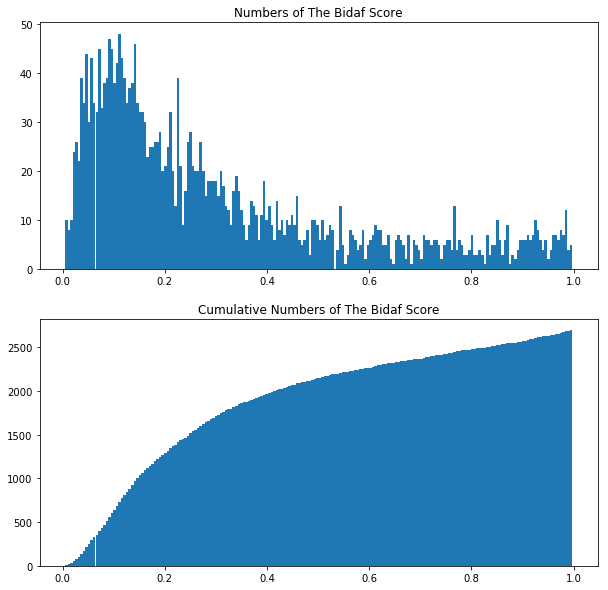

Total False： 2694
Total num:  4042


In [12]:
# 统计所有bidaf不是第一个的answer的socre分布
# cover

total_num = 0
bidaf_other_score = []
def filterTrueOtherAns_cover(row):
    global bidaf_other_score, total_num
    grounds = row['ground_truth'].split('|||')
    # not top1 answer
    for idx, span in enumerate(row['bidaf'].split('|||')):
        if idx > 0:
            total_num += 1
            ans, score = span.split(':::')
#             if float(score) < 0.5:
#                 break
            ans = normalize_answer(ans)
            flag = True
            for ground in map(lambda x: normalize_answer(x), grounds):
                if ans in ground or ground in ans:
                    flag = False
                    break
            if flag:
                bidaf_other_score.append(float(score))
            
dev_pd.apply(filterTrueOtherAns_cover, axis=1)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(0, figsize=(10,10))

plt.subplot(211)
plt.title('Numbers of The Bidaf Score')
plt.hist(bidaf_other_score, bins=200)

plt.subplot(212)
plt.title('Cumulative Numbers of The Bidaf Score')
plt.hist(bidaf_other_score, bins=200, cumulative=True)

plt.show()
print ('Total False：', len(bidaf_other_score))
print ('Total num: ', total_num)

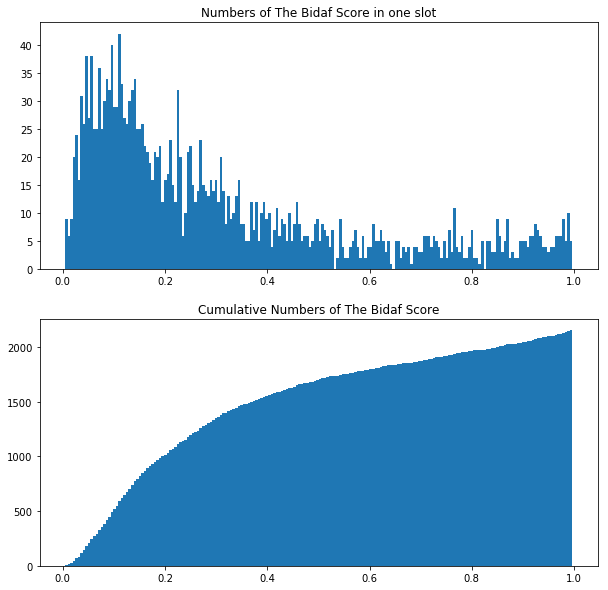

Total false： 2153
Total num:  2490


In [18]:
# 统计ground truth 为 1个slot的bibaf的top1的score分布
# cover
bidaf_other_score = []
total_num = 0
def filterTrueOtherAns_cover(row):
    global bidaf_other_score, total_num
    grounds = row['ground_truth'].split('|||')
    # not top1 answer
    if len(grounds) == 1:
        for idx, span in enumerate(row['bidaf'].split('|||')):
            if idx > 0:
                total_num += 1
                ans, score = span.split(':::')
                ans = normalize_answer(ans)
                flag = True
                for ground in map(lambda x: normalize_answer(x), grounds):
                    if ans in ground or ground in ans:
                        flag = False
                        break
                if flag:
                    bidaf_other_score.append(float(score))
                    
dev_pd.apply(filterTrueOtherAns_cover, axis=1)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(0, figsize=(10,10))

plt.subplot(211)
plt.title('Numbers of The Bidaf Score in one slot')
plt.hist(bidaf_other_score, bins=200)

plt.subplot(212)
plt.title('Cumulative Numbers of The Bidaf Score')
plt.hist(bidaf_other_score, bins=200, cumulative=True)

plt.show()
print ('Total false：', len(bidaf_other_score))
print ('Total num: ', total_num)

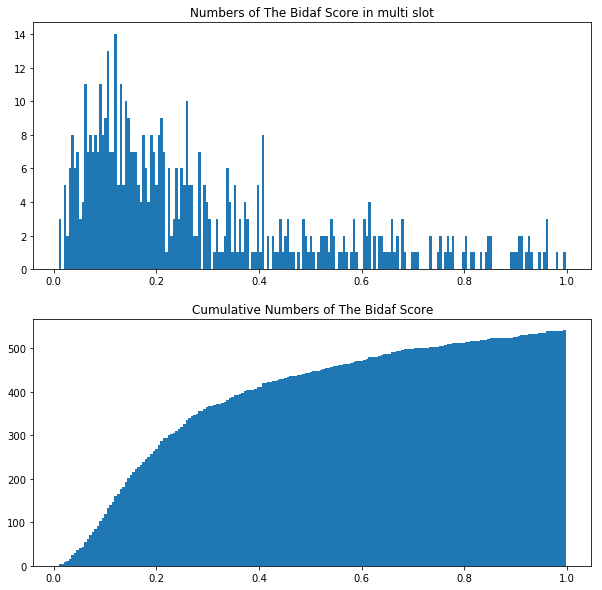

Total false： 541
Total num:  1552


In [17]:
# 统计ground truth 为 多个slot的bibaf的top1的score分布
# cover
bidaf_other_score = []
total_num = 0
def filterTrueOtherAns_cover(row):
    global bidaf_other_score, total_num
    grounds = row['ground_truth'].split('|||')
    # not top1 answer
    if len(grounds) > 1:
        for idx, span in enumerate(row['bidaf'].split('|||')):
            if idx > 0:
                total_num += 1
                ans, score = span.split(':::')
                ans = normalize_answer(ans)
                flag = True
                for ground in map(lambda x: normalize_answer(x), grounds):
                    if ans in ground or ground in ans:
                        flag = False
                        break
                if flag:
                    bidaf_other_score.append(float(score))
                    
dev_pd.apply(filterTrueOtherAns_cover, axis=1)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(0, figsize=(10,10))

plt.subplot(211)
plt.title('Numbers of The Bidaf Score in multi slot')
plt.hist(bidaf_other_score, bins=200)

plt.subplot(212)
plt.title('Cumulative Numbers of The Bidaf Score')
plt.hist(bidaf_other_score, bins=200, cumulative=True)

plt.show()
print ('Total false：', len(bidaf_other_score))
print ('Total num: ', total_num)